In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [52]:
df = pd.read_csv("Hitters.csv")
df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [53]:
print(df["Salary"].isnull().sum())

59


In [54]:
df = df.dropna().drop('Player', axis=1)
print(df.shape)
print(df["Salary"].isnull().sum())

(263, 20)
0


In [30]:
lm = ols("Salary ~ AtBat+Hits+HmRun+Runs+RBI+Walks+Years+CAtBat+CHits+CHmRun+CRuns+CRBI+CWalks+League+Division+PutOuts+Assists+Errors+NewLeague", data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     15.39
Date:                Sun, 29 May 2022   Prob (F-statistic):           7.84e-32
Time:                        14:50:02   Log-Likelihood:                -1876.2
No. Observations:                 263   AIC:                             3792.
Df Residuals:                     243   BIC:                             3864.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        163.1036     90.779      1.797      0.074     -15.710     341.917
League[T.N]       62.5994     79.261      0.790      0.430     -93.528     218.727
Division[T.W]   -116.8492     40.367     -2.895      0.004    -196.363     -37.335
NewLeague[T.N]   -24.7623     79.003     -0.313      0.754    -180.380     130.855
AtBat             -1.9799      0.634     -3.123      0.002      -3.229      -0.731
Hits               7.5008      2.378      3.155      0.002       2.818      12.184
HmRun              4.3309      6.201      0.698      0.486      -7.885      16.546
Runs              -2.3762      2.981     -0.797      0.426      -8.248       3.495
RBI               -1.0450      2.601     -0.402      0.688      -6.168       4.078
Walks              6.2313      1.829      3.408      0.001       2.630       9.833
Years             -3.4891     12.412     -0.281      0.779     -27.938      20.960
CAtBat            -0.1713      0.135     -1.267      0.206      -0.438       0.095
CHits              0.1340      0.675      0.199      0.843      -1.195       1.463
CHmRun            -0.1729      1.617     -0.107      0.915      -3.358       3.013
CRuns              1.4543      0.750      1.938      0.054      -0.024       2.933
CRBI               0.8077      0.693      1.166      0.245      -0.557       2.172
CWalks            -0.8116      0.328     -2.474      0.014      -1.458      -0.165
PutOuts            0.2819      0.077      3.640      0.000       0.129       0.434
Assists            0.3711      0.221      1.678      0.095      -0.065       0.807
Errors            -3.3608      4.392     -0.765      0.445     -12.011       5.290
==============================================================================
Omnibus:                       87.414   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              452.923
Skew:                           1.236   Prob(JB):                     4.46e-99
Kurtosis:                       8.934   Cond. No.                     2.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
dummies = pd.get_dummies(df[["League", "Division", "NewLeague"]])
y = df.Salary
X_ = df.drop(["Salary", "League", "Division", "NewLeague"], axis=1).astype("float64")
X = pd.concat([X_, dummies[["League_N", "Division_W", "NewLeague_N"]]], axis=1)

In [23]:
def processSubset(feature_set):
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [26]:
def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models["RSS"].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [27]:
models = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(1,8):
    models.loc[i] = getBest(i)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.06205320358276367 seconds.
Processed  171 models on 2 predictors in 0.6890897750854492 seconds.
Processed  969 models on 3 predictors in 4.416614055633545 seconds.
Processed  3876 models on 4 predictors in 20.13647985458374 seconds.
Processed  11628 models on 5 predictors in 62.34054493904114 seconds.
Processed  27132 models on 6 predictors in 158.8755841255188 seconds.
Processed  50388 models on 7 predictors in 338.2473840713501 seconds.
Total elapsed time: 585.3371279239655 seconds.


In [31]:
print(models.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Sun, 29 May 2022   Prob (F-statistic):                    5.80e-82
Time:                        14:50:09   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [32]:
print(getBest(19)["model"].summary())

Processed  1 models on 19 predictors in 0.008168935775756836 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Sun, 29 May 2022   Prob (F-statistic):                    1.31e-76
Time:                        14:50:11   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      

In [33]:
models.loc[2, "model"].rsquared

0.7614950002332872

In [34]:
models.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

Text(0, 0.5, 'RSS')

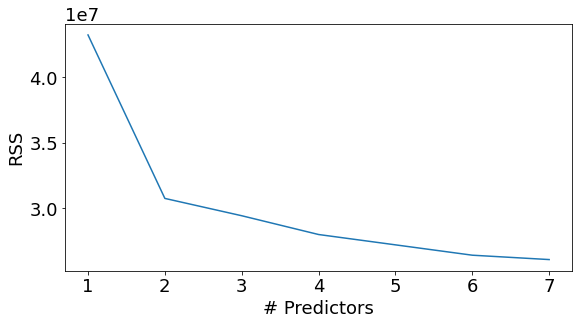

In [37]:
plt.figure(figsize=(20,10))
plt.rcParams.update({"font.size": 18, "lines.markersize": 10})
plt.subplot(2, 2, 1)
plt.plot(models["RSS"])
plt.xlabel("# Predictors")
plt.ylabel("RSS")

Text(0, 0.5, 'adjusted rsquared')

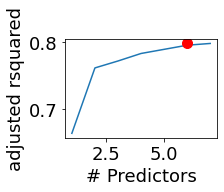

In [38]:
rsquared = models.apply(lambda row: row[1].rsquared, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared)
plt.plot(rsquared.argmax(), rsquared.max(), "or")
plt.xlabel("# Predictors")
plt.ylabel("adjusted rsquared")

Text(0, 0.5, 'AIC')

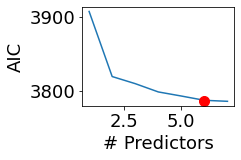

In [39]:
aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel("# Predictors")
plt.ylabel("AIC")

Text(0, 0.5, 'BIC')

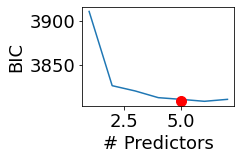

In [40]:
bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel("# Predictors")
plt.ylabel("BIC")

In [41]:
def forward(predictors):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    models = pd.DataFrame(results)
    best_model = models.loc[models["RSS"].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    return best_model

In [42]:
models2 = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
predictors = []
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.05388998985290527
Processed  18 models on 2 predictors in 0.06327128410339355
Processed  17 models on 3 predictors in 0.06703829765319824
Processed  16 models on 4 predictors in 0.1122291088104248
Processed  15 models on 5 predictors in 0.10357999801635742
Processed  14 models on 6 predictors in 0.16695594787597656
Processed  13 models on 7 predictors in 0.0862729549407959
Processed  12 models on 8 predictors in 0.14248204231262207
Processed  11 models on 9 predictors in 0.13316798210144043
Processed  10 models on 10 predictors in 0.08826398849487305
Processed  9 models on 11 predictors in 0.06533312797546387
Processed  8 models on 12 predictors in 0.06642794609069824
Processed  7 models on 13 predictors in 0.1041710376739502
Processed  6 models on 14 predictors in 0.12778210639953613
Processed  5 models on 15 predictors in 0.08379316329956055
Processed  4 models on 16 predictors in 0.012654781341552734
Processed  3 models on 17 predictors in 0

In [43]:
print(models.loc[1, "model"].summary())
print(models.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              519.2
Date:                Sun, 29 May 2022   Prob (F-statistic):                    4.20e-64
Time:                        14:50:51   Log-Likelihood:                         -1952.4
No. Observations:                 263   AIC:                                      3907.
Df Residuals:                     262   BIC:                                      3910.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [44]:
print(models.loc[6, "model"].summary())
print(models2.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              166.3
Date:                Sun, 29 May 2022   Prob (F-statistic):                    1.79e-85
Time:                        14:50:54   Log-Likelihood:                         -1887.6
No. Observations:                 263   AIC:                                      3787.
Df Residuals:                     257   BIC:                                      3809.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [45]:
def backward(predictors):
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models["RSS"].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic))
    return best_model

In [46]:
models3 = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))
tic = time.time()
predictors = X.columns
while(len(predictors) > 1):
    models3.loc[len(predictors)-1] = backward(predictors)
    predictors = models3.loc[len(predictors)-1]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.054208993911743164
Processed  18 models on 17 predictors in 0.0358729362487793
Processed  17 models on 16 predictors in 0.03862595558166504
Processed  16 models on 15 predictors in 0.1711139678955078
Processed  15 models on 14 predictors in 0.18405604362487793
Processed  14 models on 13 predictors in 0.17104005813598633
Processed  13 models on 12 predictors in 0.09508490562438965
Processed  12 models on 11 predictors in 0.08671689033508301
Processed  11 models on 10 predictors in 0.11267209053039551
Processed  10 models on 9 predictors in 0.08164095878601074
Processed  9 models on 8 predictors in 0.05593228340148926
Processed  8 models on 7 predictors in 0.05364513397216797
Processed  7 models on 6 predictors in 0.047963857650756836
Processed  6 models on 5 predictors in 0.0333559513092041
Processed  5 models on 4 predictors in 0.01954483985900879
Processed  4 models on 3 predictors in 0.018106937408447266
Processed  3 models on 2 predictors i

In [47]:
print(models.loc[7, "model"].params)

Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [48]:
print(models2.loc[7, "model"].params)

Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [49]:
print(models3.loc[7, "model"].params)

AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64
